# Crawl Data Analysis: Clustering

This notebook tries various clustering techniques on our web crawl data. It was written for Python 2.7, and assumes it's running on cycles. You can view/edit the notebook remotely as follows:

- Clone the GitHub repo to cycles (e.g. spin.cs.princeton.edu)
- Start up this notebook. Jupyter is not installed globally, but you can install it locally with pip via `pip install --user jupyter`. Then you can run this notebook in a tmux session: `tmux`, then `cd [this directory]`, then `jupyter notebook --no-browser --port 8889` (note that you can choose whatever port number you want, but we'll assume from here on it's 8889). Copy the URL generated - this is the URL you'll visit in your browser to open the notebook. Then Ctrl-B, D to detach the tmux session, and log out of cycles.
- On your local machine, forward your local port 8889 to the remote port 8889 on cycles: `ssh -L 8889:localhost:8889 [netid]@spin.cs.princeton.edu`
- Now you can open the notebook in your browser by pasting the link you copied earlier.

In [88]:
from __future__ import print_function
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os

## Read from database

Read the crawl data from the database. Here we read in the `site_visits` and `segments` tables and join them.

In [89]:
import sqlite3
import pandas as pd

db = '/n/fs/darkpatterns/crawl/2018-12-08_segmentation_pilot2/2018-12-08_segmentation_pilot2.sqlite'
con = sqlite3.connect(db)
site_visits = pd.read_sql_query('''SELECT * from site_visits''', con)

In [90]:
print('Number of site visits: %s' % str(site_visits.shape))
print('site_visits columns: %s' % str(list(site_visits.columns.values)))

Number of site visits: (2839, 3)
site_visits columns: ['visit_id', 'crawl_id', 'site_url']


Report how many unique domains we have.

In [91]:
from urlparse import urlparse

site_visits['domain'] = site_visits['site_url'].apply(lambda x: urlparse(x).netloc)
grouped = site_visits.groupby(['domain']).count().sort_values('visit_id', ascending=False)

In [92]:
print('Number of unique domains: %s' % str(grouped.shape[0]))

Number of unique domains: 630


In [93]:
segments = pd.read_sql_query('''SELECT * from segments''', con)

In [95]:
segments = segments.reset_index().set_index('visit_id').join(site_visits.reset_index()[['visit_id', 'site_url', 'domain']].set_index('visit_id'), how='inner')

In [169]:
print('Number of segments: %s' % str(segments.shape))
print('segments columns: %s' % str(list(segments.columns.values)))

Number of segments: (75516, 29)
segments columns: ['index', 'id', 'crawl_id', 'node_name', 'node_id', 'top', 'left', 'width', 'height', 'style', 'inner_text', 'outer_html', 'longest_text', 'longest_text_width', 'longest_text_height', 'longest_text_top', 'longest_text_left', 'longest_text_style', 'num_buttons', 'num_imgs', 'num_anchors', 'time_stamp', 'site_url', 'domain', 'newline_count', 'inner_text_length', 'inner_text_processed', 'longest_text_processed', 'cluster']


## Preprocess data

Ignore `body` tags and null `inner_text`.

In [252]:
segments['inner_text'] = segments['inner_text'].str.strip()
segments = segments[(segments['node_name'] != 'BODY') & (segments['inner_text'] != '')]

Add a new column for number of newlines in each segment.

In [253]:
segments['newline_count'] = segments['inner_text'].apply(lambda x: len(x.split('\n')))

Apply some standard techniques in preprocessing string data (ref: [Kdnuggets article](https://www.kdnuggets.com/2017/06/text-clustering-unstructured-data.html)):

- Lower case
- Replacing numbers with a placeholder, and replace units of measure with a placeholder (e.g kg, sq ft, gb, etc.)
- Removing punctuation
- Removing excess whitespace
- Removing known "stop words"/"stop phrases"/generic words (articles, conjunctions, etc.)
- Stemming (reducing words to their stems, i.e. via Porter's stemming algorithm)

In [254]:
from nltk.stem.porter import PorterStemmer
import nltk
import re
import string

nltk.download('stopwords')

stemmer = PorterStemmer()
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords = stopwords.union(set(string.punctuation))

def preprocess(s):
    s = s.lower()
    s = re.sub(r'\d+', 'dpnum', s)
    s = re.sub(r'[^a-z\s]', '', s)
    s = re.sub(r'\s+', ' ', s)
    words = s.split()
    words = [stemmer.stem(w) for w in words if len(w) > 0 and w not in stopwords]
    
    # Optimization to get rid of suffixes (e.g. units of measure)
    for i in range(len(words)):
        if words[i].startswith('dpnum'):
            words[i] = 'dpnum'
    
    return ' '.join(words)

[nltk_data] Downloading package stopwords to /u/mjf4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [255]:
# Sanity check
s = '''Color   
Choose an option
Silver
Space Gray

Size    
Choose an option
64 GB'''
print('ORIGINAL STRING:')
print(s)
print()
print('PREPROCESSED STRING:')
print(preprocess(s))

ORIGINAL STRING:
Color   
Choose an option
Silver
Space Gray

Size    
Choose an option
64 GB

PREPROCESSED STRING:
color choos option silver space gray size choos option dpnum gb


In [249]:
segments['inner_text_processed'] = segments['inner_text'].apply(preprocess)
segments['longest_text_processed'] = segments['longest_text'].apply(preprocess)

Add new columns for length of original text and processed text.

In [256]:
segments['inner_text_length'] = segments['inner_text'].apply(lambda x: len(x))
segments['inner_text_processed_length'] = segments['inner_text_processed'].apply(lambda x: len(x))
segments['longest_text_length'] = segments['longest_text'].apply(lambda x: len(x))
segments['longest_text_processed_length'] = segments['longest_text_processed'].apply(lambda x: len(x))

In [257]:
new_cols = ['newline_count', 'inner_text_length', 'inner_text_processed_length',
            'longest_text_length', 'longest_text_processed_length']
for c in new_cols:
    print('segments[\'%s\'].describe():\n%s' % (c, segments[c].describe().to_string()))

segments['newline_count'].describe():
count    73132.000000
mean         3.588183
std         35.198316
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       5002.000000
segments['inner_text_length'].describe():
count     73132.000000
mean        128.331428
std        1835.496827
min           1.000000
25%          14.000000
50%          30.000000
75%          67.000000
max      391699.000000
segments['inner_text_processed_length'].describe():
count     73132.000000
mean         97.876730
std        1664.877963
min           0.000000
25%          11.000000
50%          24.000000
75%          55.000000
max      378761.000000
segments['longest_text_length'].describe():
count    73132.000000
mean        48.181261
std         94.718657
min          0.000000
25%         11.000000
50%         20.000000
75%         44.000000
max       4145.000000
segments['longest_text_processed_length'].describe():
count    73132.000000
mean        34.601693
std   

Remove redundant segments.

In [258]:
segments = segments.groupby(['domain']).apply(lambda x: x.drop_duplicates(subset=['inner_text_processed'], keep='last'))

/n/fs/ugrad/ug19/mjf4/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'domain' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


In [259]:
print('Number of segments: %s' % str(segments.shape))
print('segments columns: %s' % str(list(segments.columns.values)))

Number of segments: (72072, 32)
segments columns: ['index', 'id', 'crawl_id', 'node_name', 'node_id', 'top', 'left', 'width', 'height', 'style', 'inner_text', 'outer_html', 'longest_text', 'longest_text_width', 'longest_text_height', 'longest_text_top', 'longest_text_left', 'longest_text_style', 'num_buttons', 'num_imgs', 'num_anchors', 'time_stamp', 'site_url', 'domain', 'newline_count', 'inner_text_length', 'inner_text_processed', 'longest_text_processed', 'cluster', 'inner_text_processed_length', 'longest_text_length', 'longest_text_processed_length']


Select a random subset of the data to make clustering more tractable during trial-error.

In [30]:
segments_orig = segments.copy(deep=False)
indices = np.random.choice(np.arange(segments.shape[0]), replace=False, size=25000)
segments = segments.iloc[indices,:]

In [83]:
print('segments shape: %s' % str(segments.shape))

segments shape: (75516, 28)


## Create feature vectors

First we define the a function to tokenize text as we convert text into feature vectors. 

In [101]:
from nltk.stem.porter import PorterStemmer
import nltk

nltk.download('stopwords')

stemmer = PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

def tokenize(line):
    if (line is None):
        line = ''
    tokens = [stemmer.stem(t) for t in nltk.word_tokenize(line) if len(t) != 0 and t not in stopwords and not t.isdigit()]
    return tokens

[nltk_data] Downloading package stopwords to /u/mjf4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now select one of the following cells to run to create a feature representation. Either load from the pre-existing file or recompute the features.

### 1. Bag of words

In [18]:
if os.path.isfile('output/features_bow.npy'):
    features = np.load('output/features_bow.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

data = segments['inner_text_processed']
vec = CountVectorizer(tokenizer=tokenize, binary=binary_rep, strip_accents='ascii').fit(data)

In [20]:
print('Length of vocabulary %s' % str(len(vec.vocabulary_)))

In [21]:
vec = vec.transform(data)
features = normalize(vec, axis=0)
np.save('output/features_bow.npy', features)

### 2. TFIDF

Optionally load from a file (enable that cell and disable the others that compute the TFIDF features if you have a file present).

In [33]:
if os.path.isfile('output/features_tfidf.npy'):
    features = np.load('output/features_tfidf.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')

No pre-existing file


In [260]:
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
data = segments['inner_text_processed']
vec = TfidfVectorizer(binary=False, strip_accents='ascii', max_features=1000).fit(data)
features = vec.transform(data)
np.save('output/features_tfidf.npy', features)

[nltk_data] Downloading package punkt to /u/mjf4/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [261]:
print('features shape (num_examples, num_features): %s' % str(features.shape))
print('Length of vocabulary: %s' % str(len(vec.vocabulary_)))

features shape (num_examples, num_features): (72072, 1000)
Length of vocabulary: 1000


In [262]:
sorted_vocab = sorted([(t, f) for t, f in vec.vocabulary_.iteritems()], cmp=lambda x, y: x[1] - y[1])
print('Vocabulary')
print('\n'.join(['%d: %s' % (f, t) for t, f in sorted_vocab]))

Vocabulary
0: abiet
1: abl
2: ac
3: acacia
4: accept
5: access
6: accessori
7: account
8: ace
9: acenaphthi
10: aci
11: acid
12: acryl
13: acrylamid
14: activ
15: ad
16: adapt
17: add
18: addit
19: address
20: adjust
21: admi
22: adpnum
23: advanc
24: affili
25: age
26: ago
27: agre
28: air
29: al
30: ale
31: allow
32: also
33: aluminum
34: alway
35: amaz
36: amazon
37: america
38: american
39: ammonium
40: amount
41: anoth
42: answer
43: app
44: appl
45: appli
46: applic
47: area
48: arm
49: around
50: arriv
51: art
52: artist
53: ask
54: assist
55: attach
56: auction
57: audio
58: automat
59: avail
60: away
61: azi
62: babi
63: back
64: backord
65: bag
66: balanc
67: ball
68: band
69: bank
70: bar
71: barium
72: barrel
73: base
74: basic
75: basket
76: batteri
77: bear
78: beauti
79: beck
80: bed
81: belt
82: ben
83: bentonit
84: benzenesul
85: benzyl
86: best
87: better
88: bi
89: big
90: bike
91: bill
92: bisphenol
93: bit
94: black
95: blanc
96: blend
97: block
98: blog
99: blou
1

### 3. Word Vectors

We compute a vector for each segment as follows: compute the word vector for each word in the segment's `inner_text`, and then average over all words in that segment.

While it's simple, there are clearly downsides to this approach:

- We lose information about word ordering
- All words are equally weighted, so words that really characterize the text are not prioritized

In [14]:
if os.path.isfile('output/features_wordvec.npy'):
    features = np.load('output/features_wordvec.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')
    import en_core_web_sm

    data = segments['inner_text_processed']
    nlp = en_core_web_sm.load()
    vecs = []
    for doc in nlp.pipe(data.str.replace(r'\d+', '').astype('unicode').values, batch_size=10000, n_threads=7):
        if doc.is_parsed:
            vecs.append(doc.vector)
        else:
            vecs.append(None)
    features = np.array(vecs)
    np.save('output/features_wordvec.npy', features)
    
print('features shape: %s' % str(features.shape))

Loaded from file
features shape: (75516, 128)


### PCA
Try using PCA to reduce the dimension of the data.

The feature matrix is expected to be provided with examples in rows (`num_examples` x `num_features`).

Projected data is given by $U^T X$, where $U$ is matrix with PCs in columns (`orig_dim` x `reduced_dim`), and $X$ is the data matrix with examples in columns (`orig_dim` x `num_examples`). In our case, $U^T$ is `pca.components_` and $X$ is `features.T`.

In [15]:
if os.path.isfile('output/features_proj.npy'):
    features = np.load('output/features_proj.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=5)
    # pca = PCA(tol=10)
    pca.fit(features)
    
    print('Matrix of PCs: %s' % str(pca.components_.shape))
    print('Data matrix: %s' % str(features.shape))
    print('%d singular values: %s' % (pca.singular_values_.shape[0], str(pca.singular_values_)))
    
    features = np.dot(pca.components_, features.T)
    features = features.T
    
    np.save('output/features_proj.npy', features)
    
print('feature matrix shape (after PCA): %s' % str(features.shape))

Loaded from file
feature matrix shape (after PCA): (75516, 5)


Plot the data in the reduced dimension (assuming new dimension is 3, otherwise this is meaningless).

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features[:,0], features[:,1], features[:,2])

## Clustering

Run one of the following clustering algorithms.

### 1. Hierarchical clustering

In [23]:
from scipy.spatial import distance
import fastcluster

# featdense = features.todense()
distances = distance.pdist(features, metric='cosine')
distances = distance.squareform(distances, checks=False)

In [ ]:
clusters = fastcluster.linkage(distances, method='ward', preserve_input=False)
np.save('output/hierarchical_linkage_matrix.npy', clusters)

Plot a dendogram of the resulting clusters.

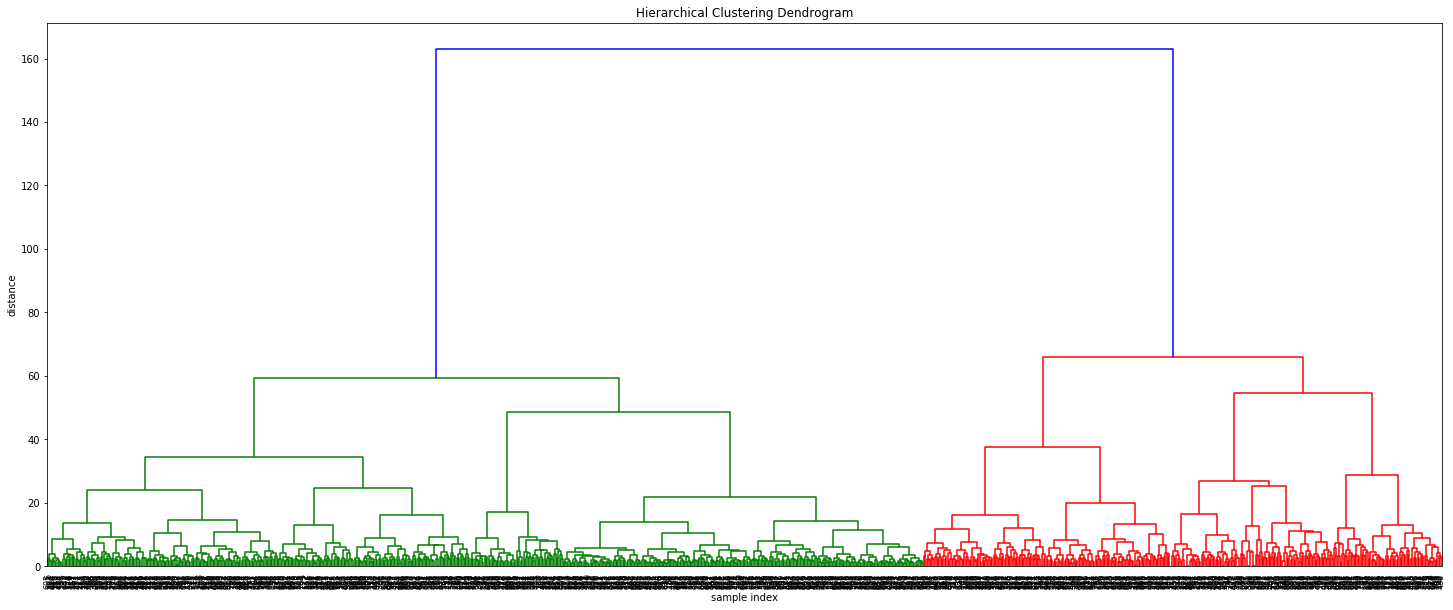

In [151]:
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    clusters,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

### 2. DBSCAN clustering

In [269]:
from sklearn.cluster import DBSCAN
from sklearn.externals.joblib.parallel import parallel_backend

with parallel_backend('threading'):
    clusterer = DBSCAN(eps=0.0001, min_samples=3, n_jobs=10, metric='euclidean')
    cluster_labels = clusterer.fit(features)

In [270]:
segments['cluster'] = pd.Series(cluster_labels.labels_).values

In [271]:
print('segments[\'cluster\'].value_counts(): \n %s' % segments['cluster'].value_counts().to_string())

segments['cluster'].value_counts(): 
 -1       36142
 0        9921
 1        3117
 34        274
 13        218
 133       158
 144       158
 35        156
 131       152
 302       143
 135       140
 38        138
 98        133
 30        131
 326       125
 384       122
 28        117
 151       116
 32        113
 37        112
 1386      112
 104       111
 956       109
 68        104
 230       102
 185       102
 33        101
 208       100
 112        94
 69         92
 51         85
 141        83
 227        80
 1644       80
 109        78
 225        77
 36         77
 172        77
 290        75
 366        74
 123        73
 481        72
 624        72
 64         71
 214        70
 130        68
 106        66
 856        66
 628        65
 80         65
 65         65
 137        64
 71         64
 1194       63
 73         62
 234        62
 724        60
 451        60
 297        60
 136        59
 169        58
 727        58
 322        57
 409        57
 6

### 3. HDBSCAN clustering

In [97]:
from sklearn.preprocessing import normalize
import hdbscan

features = normalize(features, axis=1) # Normalize each segment since using euclidean distance metric
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
cluster_labels = clusterer.fit_predict(features)
segments['cluster'] = pd.Series(cluster_labels).values

In [98]:
print('segments[\'cluster\'].value_counts(): \n %s' % segments['cluster'].value_counts().to_string())

## Visualize results

Produce a CSV file that shows the segments in each cluster.

In [266]:
inner_texts = segments['inner_text']
cluster_labels = segments['cluster']
urls = segments['site_url']
print("segments['inner_text'] is %s, segments['cluster'] is %s, segments['site_url'] is %s (should be the same)" % (str(inner_texts.shape), str(cluster_labels.shape), str(urls.shape)))

segments['inner_text'] is (72072,), segments['cluster'] is (72072,), segments['site_url'] is (72072,) (should be the same)


Group the segments by cluster.

In [267]:
from collections import defaultdict

inner_text_by_cluster = defaultdict(lambda: [])
url_by_cluster = defaultdict(lambda: [])
for i in range(inner_texts.shape[0]):
    inner_text_by_cluster[str(cluster_labels[i])].append(inner_texts[i])
    url_by_cluster[str(cluster_labels[i])].append(urls[i])

Write CSV file.

In [268]:
import unicodecsv as csv
from datetime import datetime

timestamp = '_'.join(str(datetime.now()).split(' '))
outfile = 'output/clusters-%s.csv' % timestamp
with open(outfile, 'wb') as f:
    writer = csv.writer(f)
    for cluster in inner_text_by_cluster.keys():
        segments_str = '\n\n'.join(inner_text_by_cluster[cluster])
        writer.writerow([cluster, segments_str, url_by_cluster[cluster]])